## Tensorflow Object Detection API 簡單測試

In [1]:
# 載入套件
import os
import pathlib
import tensorflow as tf
import pathlib

## GPU 記憶體配置設定

In [2]:
# GPU 設定為 記憶體動態調整 (dynamic memory allocation)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
 GPU 設定為固定為 2GB 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:  # 1024*2：2048MB = 2GB
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])

## 下載模型

In [2]:
# 下載模型，並解壓縮
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    # 解壓縮
    model_dir = tf.keras.utils.get_file(fname=model_name,
                            origin=base_url + model_date + '/' + model_file,
                            untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
PATH_TO_MODEL_DIR

'C:\\Users\\mikec\\.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32'

## 檢查模型目錄

In [3]:
# 讀取 PATH_TO_MODEL_DIR 目錄下所有目錄及檔案
from os import listdir
from os.path import isfile, join
from os import path

for f in listdir(PATH_TO_MODEL_DIR):
    print(f)

checkpoint
pipeline.config
saved_model


## 從下載的目錄載入模型

In [4]:
# 不顯示警告訊息
import warnings
warnings.filterwarnings('ignore')   # Suppress warnings

In [5]:
# 從下載的目錄載入模型，耗時甚久
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('載入模型...', end='')
start_time = time.time()

# 載入模型
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'共花費 {elapsed_time} 秒.')

載入模型...

共花費 171.27492904663086 秒.


## 建立 Label 的對照表

In [6]:
# 下載 labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models'
    base_url += '/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)
PATH_TO_LABELS

8192/5056 [================================================] - 0s 0us/step


'C:\\Users\\mikec\\.keras\\datasets\\mscoco_label_map.pbtxt'

In [7]:
# 建立 Label 的對照表 (代碼與名稱)
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS, use_display_name=True)

## 選一張圖片進行物件偵測

In [8]:
# 任選一張圖片進行物件偵測
import numpy as np
from PIL import Image

# 開啟一張圖片
image_np = np.array(Image.open('./images_Object_Detection/zebra.jpg'))

# 轉為 TensorFlow tensor 資料型態
input_tensor = tf.convert_to_tensor(image_np)
# 加一維，變為 (筆數, 寬, 高, 顏色)
input_tensor = input_tensor[tf.newaxis, ...]

# detections：物件資訊 內含 (候選框, 類別, 機率)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
print(f'物件個數：{num_detections}')
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}

detections['num_detections'] = num_detections
# 轉為整數
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

print(f'物件資訊 (候選框, 類別, 機率)：')
for detection_boxes, detection_classes, detection_scores in \
    zip(detections['detection_boxes'], detections['detection_classes'], 
        detections['detection_scores']):
    print(np.around(detection_boxes,4), detection_classes, 
          round(detection_scores*100, 2))

物件個數：100
物件資訊 (候選框, 類別, 機率)：
[0.2647 0.5269 0.6977 0.8749] 24 98.77
[0.2243 0.2899 0.6752 0.6357] 24 98.19
[0.247  0.0723 0.6775 0.3546] 24 97.23
[0.2958 0.     0.4356 0.0021] 24 3.25
[0.2263 0.     0.4017 0.002 ] 24 3.06
[0.344  0.9967 0.478  1.    ] 24 2.85
[0.3139 0.9975 0.6764 1.    ] 24 2.7
[0.3315 0.9976 0.5939 0.9998] 24 2.68
[0.3326 0.9964 0.4505 1.    ] 16 2.3
[0.2882 0.9967 0.4172 1.    ] 24 2.3
[3.322e-01 1.000e-04 5.546e-01 1.800e-03] 24 2.26
[0.339  0.9966 0.47   1.    ] 16 2.25
[0.2319 0.9972 0.4219 1.    ] 24 2.22
[0.3706 0.     0.568  0.0018] 24 2.16
[0.3511 0.9969 0.4839 1.    ] 16 2.05
[0.2636 0.     0.429  0.0022] 16 1.98
[0.2873 0.     0.4312 0.0022] 16 1.96
[0.4151 0.9977 0.7305 1.    ] 24 1.91
[0.3211 0.     0.4616 0.0018] 16 1.86
[1.745e-01 1.000e-04 3.628e-01 1.500e-03] 24 1.8
[4.549e-01 4.000e-04 6.908e-01 1.800e-03] 24 1.75
[0.1509 0.998  0.3865 1.    ] 24 1.75
[0.2263 0.     0.4017 0.002 ] 16 1.74
[0.3285 0.9965 0.429  1.    ] 24 1.69
[4.937e-01 2.000e-04 7.2

## 篩選Bounding Box，並將圖片的物件加框

In [9]:
import matplotlib.pyplot as plt

image_np_with_detections = image_np.copy()
# 加框
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

# 顯示，無效
plt.figure(figsize=(12,8))
plt.imshow(image_np_with_detections, cmap='viridis')
plt.show()

## 顯示處理後的圖片

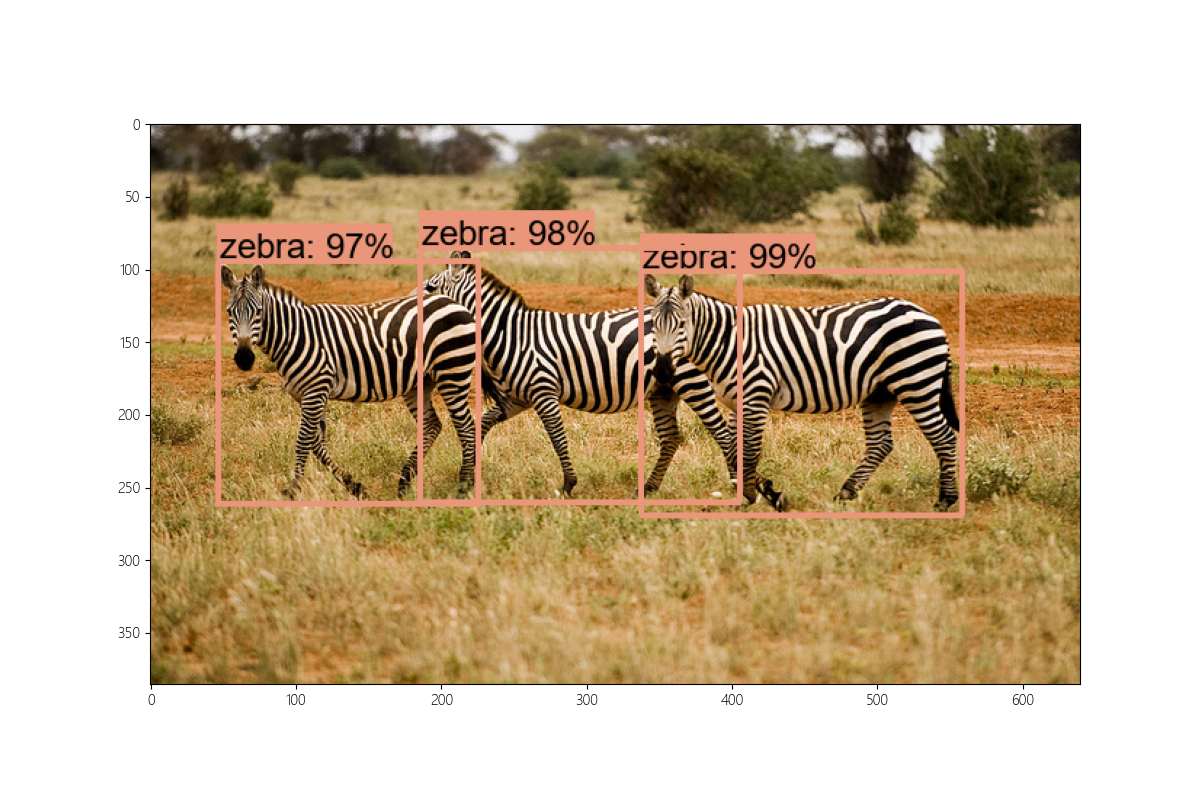

In [10]:
# 存檔
saved_file = './images_Object_Detection/zebra._detection1.png'
plt.savefig(saved_file)

# 顯示
from IPython.display import Image
Image(saved_file)

## 從下載的目錄載入模型另一種方法，非常快速

In [11]:
# 快速從下載的目錄載入模型
import time
from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

# 組態檔及模型檔路徑
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

# 計時開始
print('Loading model... ', end='')
start_time = time.time()

# 載入組態檔，再建置模型
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, 
                                      is_training=False)

# 還原模型
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

# 計時完成
end_time = time.time()
elapsed_time = end_time - start_time
print(f'共花費 {elapsed_time} 秒.')

Loading model... 共花費 0.7653965950012207 秒.


In [14]:
# 任選一張圖片進行物件偵測
import numpy as np 
from PIL import Image

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

# 讀取圖檔
image_np = np.array(Image.open('./images_Object_Detection/zebra.jpg'))
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
input_tensor = input_tensor[tf.newaxis, ...]
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))

print(f'物件個數：{num_detections}')
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
print(f'物件資訊 (候選框, 類別, 機率)：')
for detection_boxes, detection_classes, detection_scores in \
    zip(detections['detection_boxes'], detections['detection_classes'], 
        detections['detection_scores']):
    print(np.around(detection_boxes,4), int(detection_classes)+1, 
          round(detection_scores*100, 2))

# 結果存入 detections 變數
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


物件個數：100
物件資訊 (候選框, 類別, 機率)：
[0.2647 0.5269 0.6977 0.8749] 24 98.77
[0.2243 0.2899 0.6752 0.6357] 24 98.19
[0.247  0.0723 0.6775 0.3546] 24 97.23
[0.2958 0.     0.4356 0.0021] 24 3.25
[0.2263 0.     0.4017 0.002 ] 24 3.06
[0.344  0.9967 0.478  1.    ] 24 2.85
[0.3139 0.9975 0.6764 1.    ] 24 2.7
[0.3315 0.9976 0.5939 0.9998] 24 2.68
[0.3326 0.9964 0.4505 1.    ] 16 2.3
[0.2882 0.9967 0.4172 1.    ] 24 2.3
[3.322e-01 1.000e-04 5.546e-01 1.800e-03] 24 2.26
[0.339  0.9966 0.47   1.    ] 16 2.25
[0.2319 0.9972 0.4219 1.    ] 24 2.22
[0.3706 0.     0.568  0.0018] 24 2.16
[0.3511 0.9969 0.4839 1.    ] 16 2.05
[0.2636 0.     0.429  0.0022] 16 1.98
[0.2873 0.     0.4312 0.0022] 16 1.96
[0.4151 0.9977 0.7305 1.    ] 24 1.91
[0.3211 0.     0.4616 0.0018] 16 1.86
[1.745e-01 1.000e-04 3.628e-01 1.500e-03] 24 1.8
[4.549e-01 4.000e-04 6.908e-01 1.800e-03] 24 1.75
[0.1509 0.998  0.3865 1.    ] 24 1.75
[0.2263 0.     0.4017 0.002 ] 16 1.74
[0.3285 0.9965 0.429  1.    ] 24 1.69
[4.937e-01 2.000e-04 7.2

## 候選框篩選，並將圖片的物件加框

In [15]:
# 將物件框起來
# min_score_thresh=.30 表機率(Confidence)至少要大於 30%
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes']+1,
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(12,8))
plt.imshow(image_np_with_detections, cmap='viridis')
plt.show()

## 顯示處理後的圖片

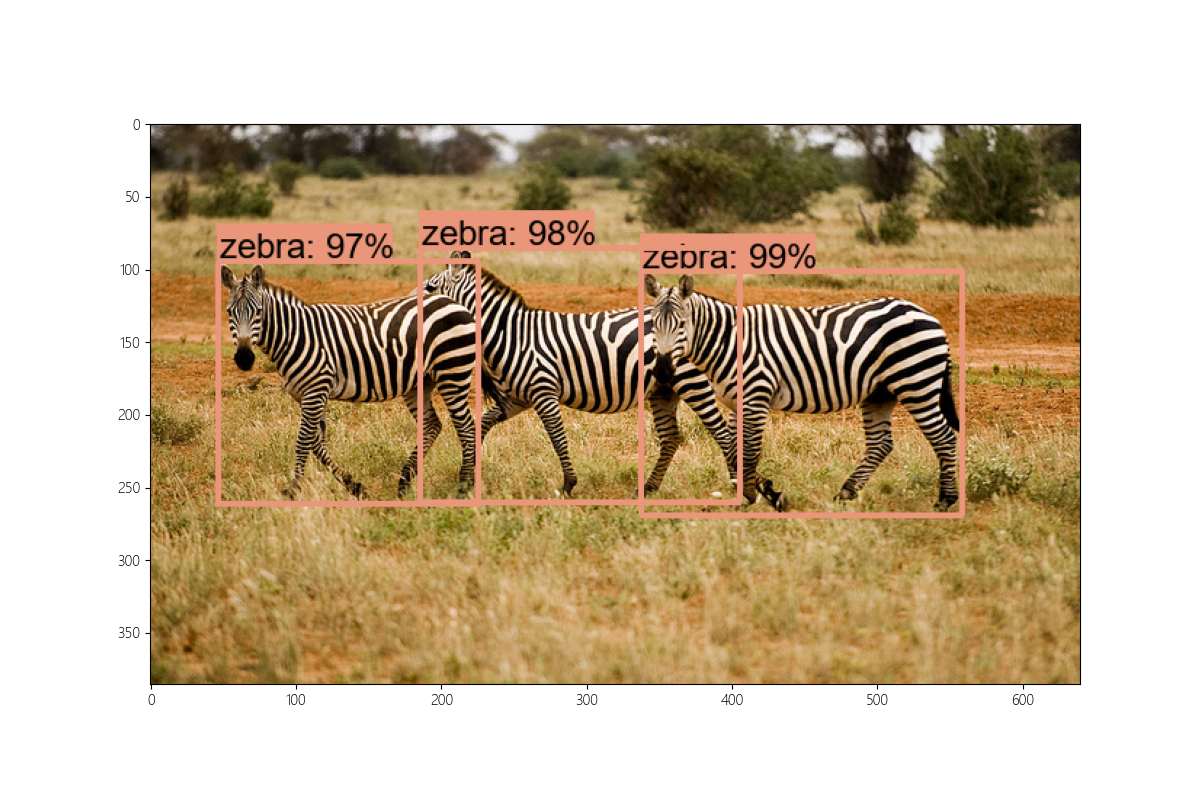

In [16]:
# 存檔
saved_file = './images_Object_Detection/zebra._detection2.png'
plt.savefig(saved_file)

# 顯示
from IPython.display import Image
Image(saved_file)